# Deploy a BQML customer churn propensity model to Vertex AI for online predictions

## Learning objectives

* Train a BQML classifier to predict customer churn.
* Evaluate the performance of a BQML classifier.
* Explain your model with BQML Explainable AI.
* Export a BQML model to Vertex AI Endpoint for online predictions.

## Introduction: customer propensity modeling in the mobile gaming industry

## Setup

### Define constants

In [41]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

In [2]:
BQ_LOCATION = 'US'
REGION = 'us-central1'

### Import libraries

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
import numpy as np
import pandas as pd

### Create a GCS bucket for artifact storage

In [4]:
# Create a globally unique Google Cloud Storage bucket for artifact storage.
GCS_BUCKET = f"{PROJECT_ID}-bucket"

In [5]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://dougkelly-vertex-demos-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'dougkelly-vertex-demos-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Create a BigQuery dataset

In [6]:
BQ_DATASET = f"{PROJECT_ID}:bqmlga4"

In [7]:
!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

BigQuery error in mk operation: Dataset 'dougkelly-vertex-demos:bqmlga4' already
exists.


### Initialize the Vertex Python SDK client

Import the Vertex SDK for Python into your Python environment and initialize it.

In [8]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

## Exploratory Data Analysis (EDA) in BigQuery

This lab uses a [public BigQuery dataset]() that contains raw event data from a real mobile gaming app called **Flood it!** ([Android app](), [iOS app]()).

The data schema originates from Google Analytics for Firebase but is the same schema as Google Analytics 4.

In [9]:
# %%bigquery --project $PROJECT_ID

# SELECT 
#     *
# FROM
#   `firebase-public-project.analytics_153293282.events_*`
    
# TABLESAMPLE SYSTEM (1 PERCENT)

In [10]:
%%bigquery --project $PROJECT_ID

SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.87s/rows]


,count_distinct_users,count_events
0,15175,5700000


## Dataset preparation in BigQuery

### Defining churn for each user

In [11]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.returningusers AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    #add 24 hr to user's first touch
    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,

#churned = 1 if last_touch within 24 hr of app installation, else 0
IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,

#bounced = 1 if last_touch within 10 min, else 0
IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

SELECT 
  * 
FROM 
  bqmlga4.returningusers 
LIMIT 100;

Downloading: 100%|██████████| 100/100 [00:01<00:00, 86.63rows/s] 


,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,841A68D5D1F94857BEB64225193B2432,1532036921992004,1534990773878015,7,200,5,1532123321992004,0,0
1,F4634EFF4D9470DCA00051E3304B81AF,1531702212886008,1537620853356101,7,197,2,1531788612886008,0,0
2,D9AA0EC27AF47514DDB5C664A6EF758A,1529542142552009,1538614037069093,6,172,5,1529628542552009,0,0
3,AA35092B507100A45CBF225A23D56864,1532898850618009,1533641233967122,7,210,1,1532985250618009,0,0
4,EC1A759709685E136767F2C1BA4751ED,1533172006084000,1533249051573000,8,214,5,1533258406084000,1,0
...,...,...,...,...,...,...,...,...,...
95,8705B2418CB08B853AA2959AC1D5D4CC,1528919871991011,1537391175858000,6,164,4,1529006271991011,0,0
96,3D4D86AC719A6FF6D461DD5B3A82988C,1528937104197010,1538097283375104,6,165,5,1529023504197010,0,0
97,185D4D668E346E59436AE24454ED5CFF,1537401477449001,1537406478319000,9,262,4,1537487877449001,1,0
98,0CB4A2594E1F4E341283EACAFADEEA6B,1537389337344006,1537395075883001,9,262,4,1537475737344006,1,0


In [12]:
%%bigquery --project $PROJECT_ID

SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.returningusers
GROUP BY 1,2
ORDER BY bounced

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.55rows/s]


,bounced,churned,count_users
0,0,0,6148
1,0,1,1883
2,1,1,5557


In [13]:
%%bigquery --project $PROJECT_ID

SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.returningusers
WHERE bounced = 0

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.40s/rows]


,churn_rate
0,0.234466


### Extract user demographic features

In [14]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.17rows/s]


,user_pseudo_id,country,operating_system,language
0,0144954795B93A124C5D1E0BF7B55CAF,United States,IOS,en-us
1,0175F289F0878C46DCA6B0AF3C5677F1,United States,IOS,en-us
2,05AFD9CC6BE47271BCD774268D50ACCC,United States,IOS,en-us
3,060ADA8C8F2558D7C9AC00CA15B84DB3,United States,IOS,en-us
4,07BF2220AEC9352DF006C0AF64733E0F,United States,IOS,en-us
5,0E05204A44E4CA8857B83A2FED471037,United States,ANDROID,en-us
6,0E66030347F325DEF689D46EF5765856,United Kingdom,IOS,en-gb
7,13282343584D1E29C354588A314C81B7,United States,IOS,en-us
8,14B3164775DC217E7AC2C1BD7D250D96,United States,ANDROID,en-us
9,153EB882FE1C43202528F580B9B5A250,United States,IOS,en-us


### Aggregate user behavioral features

In [15]:
%%bigquery --project $PROJECT_ID

SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 1
ORDER BY
   event_count DESC

Downloading: 100%|██████████| 37/37 [00:01<00:00, 26.33rows/s]


,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


In [16]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior AS (
WITH
  events_first24hr AS (
    #select user data only from first 24 hr of using the app
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.returningusers r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      e.event_timestamp <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  1
  );

SELECT
  *
FROM
  bqmlga4.user_aggregate_behavior
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.46rows/s]


,user_pseudo_id,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps
0,9671D4765AF66016ECBBE23BBC94B47C,16,0,0,0,0,4,0,0,0,0,0
1,88AD03F6828BDD86AA72AA556D87387B,7,0,0,0,0,1,0,0,0,0,0
2,DE9B57ADB713AD87D755A19E5827551E,26,37,5,1,31,1,0,0,0,0,0
3,27DF439BFD9C3BB0CB0D636030E61F57,85,10,9,2,0,7,4,1,0,0,4
4,D30F2220312E9771CD8E4FB754A632BF,4,2,1,1,0,1,0,0,0,0,0
5,C6099401764D6B1AA87396939E3F2A71,22,6,4,4,1,4,0,0,0,0,0
6,17405ECCBFAADD8F74856F658C4DCBEF,16,11,3,2,8,2,2,0,0,0,2
7,29574BB59EAA97D018CE2997AD553C38,15,0,0,0,0,4,0,0,0,0,0
8,7B939BF8414AB69B7F080956374D3B68,7,1,0,0,0,0,0,0,0,0,0
9,78F8F9830EBD020AFAA6B6608E673C62,1,0,0,0,0,0,0,0,0,0,0


In [148]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.ml_features AS (
    
  SELECT
    dem.user_pseudo_id,
    dem.country,
    dem.operating_system,
    dem.language,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    ret.user_first_engagement,
    ret.month,
    ret.julianday,
    ret.dayofweek,
    ret.churned,
    # 80% train (false), 20% evaluation (true)
    IF(ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) < 8, False, True) AS data_split
  FROM
    bqmlga4.returningusers ret
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    ret.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_aggregate_behavior beh
  ON
    ret.user_pseudo_id = beh.user_pseudo_id
  WHERE ret.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.ml_features
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.55rows/s]


,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,...,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned,data_split
0,40E86F2B5D4C7837A3D2BBC1AF18461F,United States,IOS,en-us,5,2,1,0,0,1,...,0,0,0,0,1530043073720008,6,177,3,0,False
1,83C4BA9FE06C0365B44B758ACDB4212A,United States,IOS,en-us,194,73,69,0,0,0,...,0,0,0,0,1529326105119003,6,169,2,0,False
2,1956E77F32295519C4828352F607C573,Japan,IOS,ja-jp,8,2,2,1,0,1,...,0,0,0,0,1536235378597009,9,249,5,0,False
3,EFB696A82D093B3AFBE92FF526DD5CEA,United States,IOS,en-us,188,54,51,2,0,2,...,0,0,0,0,1530158013305014,6,179,5,0,True
4,969928EC33029CB2E91CE4B9BA96728D,United States,IOS,en-us,9,3,3,2,0,2,...,0,0,0,0,1529070683660010,6,166,6,0,False
5,772FA77A888E21BA03492B789D70D44C,United States,IOS,en,32,0,0,0,0,5,...,1,0,1,0,1537051358994006,9,258,7,0,False
6,377303AA2F5C5C80E5AAAD26C029BD5A,United States,IOS,en-us,55,21,19,19,0,19,...,0,0,0,0,1529804868642005,6,175,1,0,False
7,6F1C09DFB69D4CA8B61065E9A7CFE12A,United States,IOS,en-us,17,9,9,6,0,6,...,0,0,0,0,1537024830114010,9,258,7,0,False
8,918E01DFDCFA209B176CCF3C07EDB3C5,Canada,IOS,en,3,1,1,1,0,1,...,0,0,0,0,1531259188745003,7,191,3,0,True
9,6D932377481D0477E3C4ED9EA79EE410,United States,IOS,en-us,11,3,3,3,0,3,...,0,0,0,0,1528837669603003,6,163,3,0,False


In [149]:
%%bigquery

SELECT data_split, COUNT(*)
FROM bqmlga4.ml_features
GROUP BY data_split

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.29rows/s]


,data_split,f0_
0,True,1645
1,False,6386


## Train a BQML propensity model to predict customer churn

In [118]:
MODEL_NAME='churn_xgb'

In [152]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  INPUT_LABEL_COLS=["churned"],
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  ENABLE_GLOBAL_EXPLAIN=True
) AS

SELECT
  * EXCEPT(user_pseudo_id)
FROM
  bqmlga4.ml_features

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1376.08query/s]                        


""


In [164]:
!pip list | grep 'google-cloud-bigquery'

google-cloud-bigquery            2.20.0
google-cloud-bigquery-storage    2.4.0


In [96]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL bqmlga4.churn_dnn

OPTIONS(
  MODEL_TYPE="DNN_CLASSIFIER",
  INPUT_LABEL_COLS=["churned"],
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
#   ENABLE_GLOBAL_EXPLAIN=True,
#   NUM_INTEGRAL_STEPS=50,
  LEARN_RATE=0.01,
  BATCH_SIZE=32,
  HIDDEN_UNITS=[64,32],
  DROPOUT=0.1,
  ACTIVATION_FN="RELU"
) AS

SELECT
  * EXCEPT(user_pseudo_id)
FROM
  bqmlga4.ml_features

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1383.04query/s]                        


""


## Evaluate BQML model performance

In [154]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_xgb);

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.50s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.62069,0.186047,0.781763,0.286282,0.450754,0.777391


In [97]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_dnn);

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.18s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.6875,0.085271,0.775684,0.151724,0.486752,0.731646


In [50]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.46rows/s]


,expected_label,predicted_0,predicted_1
0,0,1214,44
1,1,315,72


In [51]:
%%bigquery df_roc --project $PROJECT_ID
SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_xgb)

Downloading: 100%|██████████| 91/91 [00:01<00:00, 59.83rows/s]


<AxesSubplot:title={'center':'AUC-ROC curve'}, xlabel='false_positive_rate'>

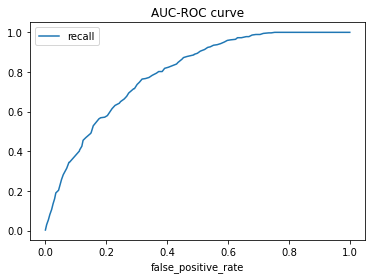

In [52]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

## Generate batch predict and explanations

In [98]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_dnn,
  (SELECT * FROM bqmlga4.ml_features WHERE data_split=True)) 

Downloading: 100%|██████████| 1645/1645 [00:02<00:00, 565.47rows/s]


,predicted_churned,predicted_churned_probs,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,...,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned,data_split
0,0,"[{'label': 1, 'prob': 0.07228875160217285}, {'...",E4196C5E0A92A22F69DE4E3AA288D6EE,United States,ANDROID,en-us,22,10,6,0,...,0,0,0,1,1529318093868006,6,169,2,0,True
1,0,"[{'label': 1, 'prob': 0.23749400675296783}, {'...",9D7FBEE36126EDDACD5524F832FCCA6A,New Zealand,ANDROID,en-nz,40,2,1,0,...,0,0,1,1,1530775165727006,7,186,5,0,True
2,0,"[{'label': 1, 'prob': 0.014222118072211742}, {...",BE36C49B1AB3968D420923AEC4FDD7AE,Japan,ANDROID,ja-jp,6,1,1,0,...,0,0,0,0,1529369892467002,6,170,3,0,True
3,0,"[{'label': 1, 'prob': 0.14176370203495026}, {'...",56B62AC76D064517A124EC916BD051A5,United States,ANDROID,en-us,27,4,3,2,...,4,0,0,4,1530323991748001,6,181,7,0,True
4,0,"[{'label': 1, 'prob': 0.10784237086772919}, {'...",42E6A7C3536775E3B8C3DB919AE9A452,United States,ANDROID,en-us,27,15,12,0,...,0,0,0,0,1529442972693003,6,170,3,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,0,"[{'label': 1, 'prob': 0.29978838562965393}, {'...",5B676202268516B467A71617A1C83CD6,Morocco,ANDROID,ar-qa,19,0,0,0,...,0,0,0,0,1534933745799001,8,234,4,1,True
1641,0,"[{'label': 1, 'prob': 0.057282257825136185}, {...",C396673C7AE50F8C274D1A525952621D,United States,ANDROID,en-us,17,2,1,0,...,0,0,0,0,1530041166914012,6,177,3,1,True
1642,1,"[{'label': 1, 'prob': 0.500342071056366}, {'la...",1756558602A5C14A5DD2AD4B696D2191,India,ANDROID,en-gb,66,4,0,0,...,0,0,0,0,1537621896876004,9,265,7,0,True
1643,0,"[{'label': 1, 'prob': 0.3883698880672455}, {'l...",611D2AC30EE506E38950643C7B4C5F20,United States,IOS,en-us,19,1,1,0,...,0,0,0,3,1535926038880001,9,245,1,1,True


In [99]:
%%bigquery --project $PROJECT_ID

SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL bqmlga4.churn_dnn,
  (SELECT * FROM bqmlga4.ml_features WHERE data_split=True))

Downloading: 100%|██████████| 1645/1645 [00:01<00:00, 1286.77rows/s]


,user_pseudo_id,churned,predicted_churned,probability_churned
0,0D6A346C85BF606BE12F9A70FC20A7B7,0,0,0.109132
1,86C0A7CE29E087F5ED9538D2C2B77EBD,0,0,0.053909
2,E512079B53179DF9A608CF4ADE47DE9D,0,0,0.017950
3,B5F3D00E28A57C9522F2DEE3CB903DD1,0,0,0.030317
4,437E1E4F1A7DF0CC995FCE10EAC96350,0,0,0.044806
...,...,...,...,...
1640,9C9F104105826B505572DDB16C22A990,1,1,0.516122
1641,23507C5F8A060402DC9563351AA9DB98,0,0,0.417356
1642,A548C8D6231CA50B3DB5BBCA75245971,1,0,0.094270
1643,4A54D2FCB3C88FA8AEB83370B9959366,0,0,0.418926


In [265]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL bqmlga4.churn_xgb)
ORDER BY
  attribution DESC

Downloading: 100%|██████████| 18/18 [00:01<00:00, 11.37rows/s]


,feature,attribution
0,cnt_user_engagement,0.283014
1,user_first_engagement,0.126458
2,julianday,0.109747
3,operating_system,0.081225
4,cnt_level_end_quickplay,0.042686
5,cnt_level_start_quickplay,0.037337
6,cnt_post_score,0.028005
7,language,0.015825
8,cnt_level_reset_quickplay,0.015175
9,cnt_level_complete_quickplay,0.012554


## Export a BQML model to Vertex AI for online predictions

### Export BQML model to GCS

In [57]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model 'dougkelly-vertex-demos:bqmlga4.churn_xgb' \
'gs://dougkelly-vertex-demos-bucket/churn_xgb'

Waiting on bqjob_r5b004b498bafea48_0000017b33a3d8b5_1 ... (2s) Current status: DONE   


### Upload BQML model to Vertex AI from GCS

In [28]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [112]:
model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri='gs://dougkelly-vertex-demos-bucket/churn_dnn',
    serving_container_image_uri=IMAGE_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/617979904441/locations/us-central1/models/7813208791813455872/operations/3164169339733540864
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/617979904441/locations/us-central1/models/7813208791813455872
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/617979904441/locations/us-central1/models/7813208791813455872')


### Deploy a Vertex `Endpoint` for online predictions

In [113]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="n1-standard-2",
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/617979904441/locations/us-central1/endpoints/6780292384308592640/operations/4445443433720446976
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/617979904441/locations/us-central1/endpoints/6780292384308592640
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/617979904441/locations/us-central1/endpoints/6780292384308592640')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/617979904441/locations/us-central1/endpoints/6780292384308592640
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/617979904441/locations/us-central1/endpoints/6780292384308592640/operations/245836781197459456
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/617979904441

### Query model for online predictions

In [165]:
CATEGORICAL_FEATURES = ['country',
                        'operating_system',
                        'language']

In [176]:
from sklearn.preprocessing import OrdinalEncoder

In [263]:
def _build_cat_feature_encoders(cat_feature_list, gcs_bucket, model_name, na_value='Unknown'):
    """
    Args:
      cat_feature_list (list):
      gcs_bucket (str):
      model_name (str):
      na_value (str): default: 'Unknown'
    Returns:
      feature_encoders (dict):
    """
    
    feature_encoders = {}
    
    for idx, feature in enumerate(CATEGORICAL_FEATURES):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{GCS_BUCKET}/{MODEL_NAME}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
    
    return feature_encoders


def preprocess_xgboost(cat_feature_list):
    """
    """
    

    feature_int = feature_encoders[feature].transform([[test_instance_dict[feature]]]).item()
    test_instance_dict[feature] = feature_int

In [258]:
%%bigquery test_df --project $PROJECT_ID 

SELECT* EXCEPT (user_pseudo_id, churned, data_split)
FROM bqmlga4.ml_features LIMIT 1;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.37s/rows]


In [259]:
test_instance_dict = test_df.iloc[0].astype(str).to_dict()

In [260]:
test_instance_dict

{'country': 'United States',
 'operating_system': 'IOS',
 'language': 'en-us',
 'cnt_user_engagement': '15',
 'cnt_level_start_quickplay': '4',
 'cnt_level_end_quickplay': '2',
 'cnt_level_complete_quickplay': '0',
 'cnt_level_reset_quickplay': '0',
 'cnt_post_score': '0',
 'cnt_spend_virtual_currency': '1',
 'cnt_ad_reward': '0',
 'cnt_challenge_a_friend': '0',
 'cnt_completed_5_levels': '0',
 'cnt_use_extra_steps': '0',
 'user_first_engagement': '1530901499471001',
 'month': '7',
 'julianday': '187',
 'dayofweek': '6'}

In [264]:
endpoint.predict(instances=[list(test_instance_dict.values())])

Prediction(predictions=[[0.2232877016067505, 0.7767122983932495]], deployed_model_id='7530871797986623488', explanations=None)

## License

In [81]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.